# Getting started with Pycea

Pycea provides a suite of tools for analyzing and visualizing phylogenetic trees. This tutorial will walk you through the basics of using Pycea.

In [ ]:
import pycea as py
import scanpy as sc
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4, 4)

## TreeData object

Pycea is designed to work with the {class}`treedata.TreeData`, a wrapper around {class}`anndata.AnnData` that adds two additional attributes, obst and vart, for storing trees of observations and variables. To learn more about `TreeData`, take a look at the [getting started guide](https://treedata.readthedocs.io/en/latest/notebooks/getting-started.html).

For this tutorial, we will use a `TreeData` containing a single tumor from the KP mouse lineage tracing dataset published by [Yang, Jones, et al. 2022](https://doi.org/10.1016/j.cell.2022.04.015).

In [ ]:
tdata = py.datasets.yang22()
tdata

TreeData object with n_obs × n_vars = 1109 × 2000
    obs: 'tumor', 'mouse', 'lane', 'fitness', 'plasticity', 'cluster', 'tree'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'priors'
    obsm: 'X_scVI', 'X_umap', 'characters'
    layers: 'counts'
    obst: '3435_NT_T1'

Here `obst` contains a single lineage tree named `3435_NT_T1`, which is represented as a {class}`nx.DiGraph`.

In [540]:
print(tdata.obst["3435_NT_T1"])

DiGraph with 1890 nodes and 1889 edges


## Plotting basics

Pycea implements an intuitive plotting language where complex plots can be built from simple components. The first step is to render the branches using {func}`pycea.pl.branches`.

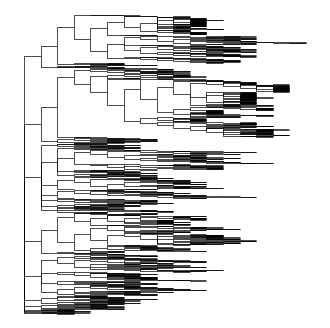

In [545]:
py.pl.branches(tdata);

{func}`pycea.pl.annotation` adds leaf annotations to a plot, such as the indels used to reconstruct the lineage tree, which are stored in `tdata.obsm["characters"]`. Here we use {func}`pycea.get.palette` to generate an indel color palette and specify that branches should be extended.

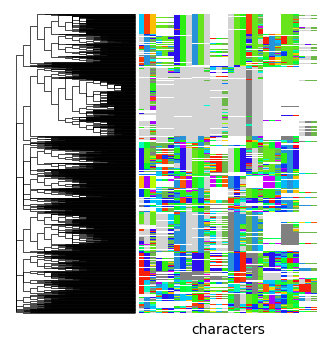

In [542]:
indel_palette = py.get.palette(
    tdata,
    "characters",
    custom={"-": "white", "*": "lightgrey"},
    cmap="gist_rainbow",
    priors=tdata.uns["priors"],
    sort="random",
    random_state=0,
)
py.pl.branches(tdata, extend_branches=True)
py.pl.annotation(tdata, keys="characters", palette=indel_palette);

{func}`pycea.pl.nodes` renders node data on a plot. For example, we can render a polar tree with internal nodes colored by their depth and leaves annotated with their estimated phylogenetic fitness from [Yang, Jones, et al. 2022](https://doi.org/10.1016/j.cell.2022.04.015).

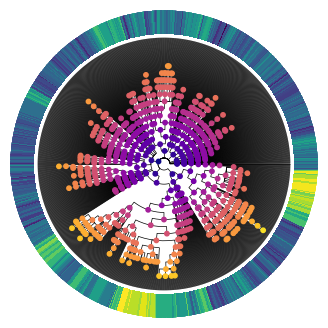

In [543]:
py.pl.branches(tdata, extend_branches=True, polar=True)
py.pl.annotation(tdata, keys="fitness", cmap="viridis", width=0.2)
py.pl.nodes(tdata, color="depth", cmap="plasma");

For convenience, Pycea also implements {func}`pycea.pl.tree` which combines the above functions. {func}`pycea.pl.tree` is useful for quickly visualizing a tree, but does not provide the same flexibility as plotting components individually.

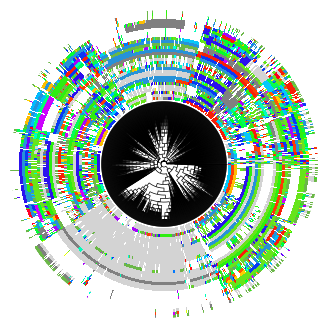

In [544]:
py.pl.tree(tdata, keys="characters", extend_branches=True, polar=True);

## Scanpy integration

Since {class}`treedata.TreeData` is a wrapper around {class}`anndata.AnnData`, it is fully compatible with the [Scverse](https://scverse.org/) ecosystem and can be used wherever {class}`anndata.AnnData` is used. For example, we can use [Scanpy](https://scanpy.readthedocs.io/en/stable/) to generate a UMAP embedding of the malignant cells' transcriptional state, colored by leiden cluster.

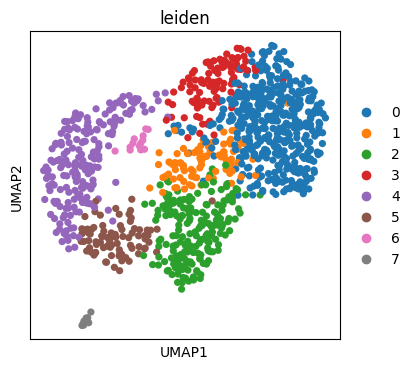

In [428]:
sc.tl.pca(tdata)
sc.pp.neighbors(tdata)
sc.tl.leiden(tdata, resolution=0.7, flavor="igraph")
sc.tl.umap(tdata, random_state=0)
sc.pl.umap(tdata, color="leiden")

We can directly analyze and plot the leiden clusters with Pycea. Here we will infer the leiden cluster of internal nodes using {func}`py.tl.ancestral_states` and then plot these on the tree.

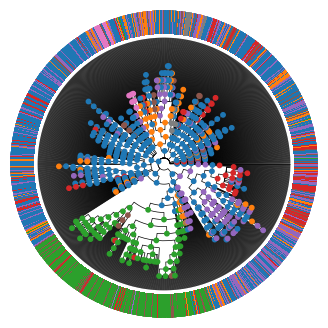

In [546]:
py.tl.ancestral_states(tdata, keys="leiden", method="fitch_hartigan")
py.pl.tree(tdata, keys="leiden", polar=True, extend_branches=True, annotation_width=0.2, node_color="leiden");

## Expression heritability

Malignant cell expression clearly varies by position in the tree but what specific genes drive these differences? One way to investigate this is by calculating the heritability of gene expression across the tree using the {func}`py.tl.autocorr` function. We first identify the 10 closest relatives for each cell then calculate the Moran's I statistic for each genewith respect to the graph structure.

In [395]:
py.tl.tree_neighbors(tdata, n_neighbors=10)
heritability = py.tl.autocorr(tdata, method="moran", copy=True)
heritability.sort_values("autocorr", ascending=False).head(10)

,autocorr,pval_norm,var_norm
Cd74,0.586375,0.0,0.000058
Ly6k,0.506656,0.0,0.000058
Krt20,0.495967,0.0,0.000058
H2-Ab1,0.446029,0.0,0.000058
Cd24a,0.443202,0.0,0.000058
Gsto1,0.440606,0.0,0.000058
Onecut2,0.433551,0.0,0.000058
Plac8,0.425292,0.0,0.000058
S100a6,0.418492,0.0,0.000058
H2-Aa,0.404116,0.0,0.000058


Cd74 has the highest Moran's I value, indicating significant heritability. We'll visualize its expression on the tree and the UMAP embedding.

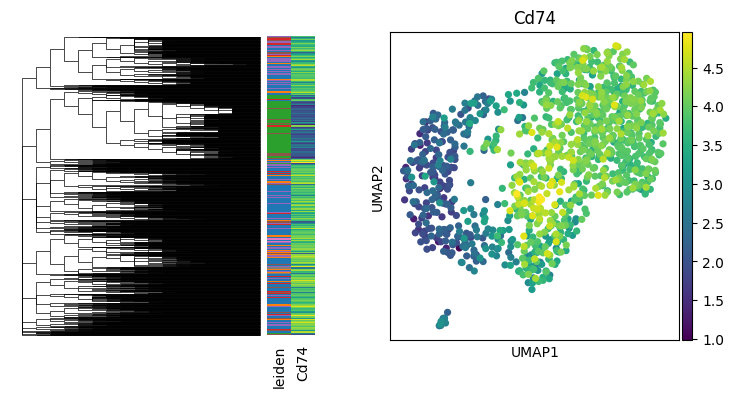

In [461]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
py.pl.tree(tdata, keys=["leiden", "Cd74"], extend_branches=True, annotation_width=0.1, ax=axes[0])
sc.pl.umap(tdata, color=["Cd74"], ax=axes[1])

## Clades and subsetting

{func}`py.tl.clades` can be used to identify clades within the tree. For example, it can label clades formed by cutting the tree at a specified depth, such as `depth=1`.

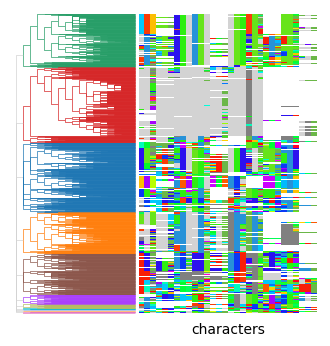

In [547]:
py.tl.clades(tdata, depth=1)
py.pl.branches(tdata, extend_branches=True, color="clade")
py.pl.annotation(tdata, keys="characters", palette=indel_palette);

We can then subset the {class}`treedata.TreeData` object to focus on a specific clade and identify subclades within it.

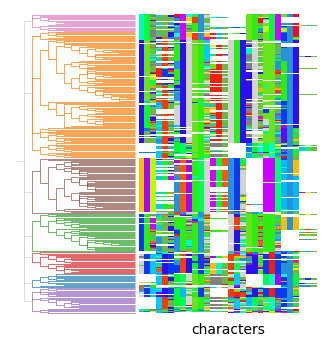

In [548]:
subset_tdata = tdata[tdata.obs["clade"] == "8"].copy()
py.tl.clades(subset_tdata, depth=2, key_added="subclade")
py.pl.branches(subset_tdata, extend_branches=True, color="subclade")
py.pl.annotation(subset_tdata, keys="characters", palette=indel_palette);

Conveniently, these clades are stored in `tdata.obs` so we can plot them on the UMAP embedding.

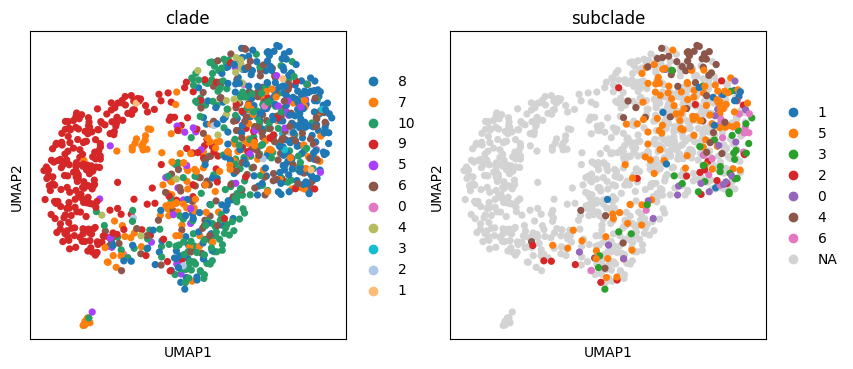

In [536]:
tdata.obs["subclade"] = subset_tdata.obs["subclade"]
sc.pl.umap(tdata, color=["clade", "subclade"])

## Learning more

This tutorial just scratches the surface of what you can do with Pycea. To learn more about Pycea's capabilities check out the full [API](https://pycea.readthedocs.io/en/latest/api.html). 

If you have any questions or feedback, please reach out by submitting an [issue](https://github.com/YosefLab/pycea/issues) on GitHub.